## Решающие деревья и ансамбли

In [165]:
import matplotlib.pyplot as plt
import scipy.stats as sps
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import pydotplus 
from IPython.display import Image
from sklearn import tree

from sklearn.datasets import load_iris, load_digits, load_breast_cancer, load_boston
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import collections

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

import IPython.display #needed to render in notebook

from sklearn import tree
import sklearn
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

# 1. Визуализация

In [99]:
data = load_iris()
X = data.data[:, [False, True, True, False]]
y = data.target

fn = np.array(data["feature_names"])[[False, True, True, False]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [88]:
def magic_plot(clf):
    cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    plt.figure(figsize=(7, 7))
    k = 1

    h = 400
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), h),
        np.linspace(X[:, 1].min(), X[:, 1].max(), h)
    )

    X_grid = np.c_[xx.ravel(), yy.ravel()]

    clf.fit(X_train, y_train)
    Z = clf.predict(X_grid)
    acc = accuracy_score(y_test, clf.predict(X_test))

    plt.title("k = {}, accuracy = {}".format(k, round(acc, 3)))
    zz = np.array(Z).reshape(xx.shape)
    plt.pcolormesh(xx, yy, zz, cmap=cmap)
    plt.xlabel(data["feature_names"][1])
    plt.ylabel(data["feature_names"][2])
    for i in range(3):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=["red", "green", "blue"][i], label=data["target_names"][i])
    plt.legend()

    plt.show()
    return clf

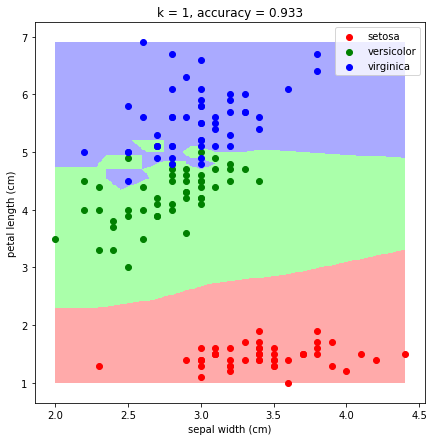

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [75]:
magic_plot(KNeighborsClassifier(n_neighbors = 1))

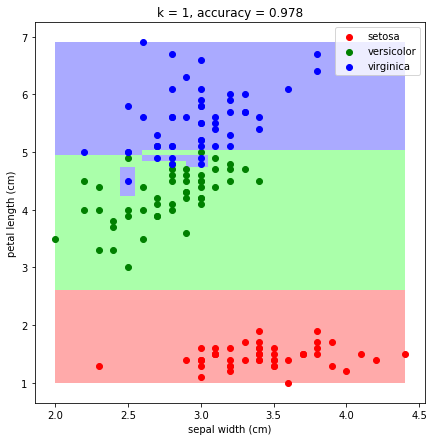

In [39]:
clf = magic_plot(DecisionTreeClassifier())

In [40]:
def draw_decision_tree(clf, column_names=None):
    dot_data = tree.export_graphviz(clf, out_file="small_tree.out",
                                    feature_names=column_names) 
    
    graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
    a = IPython.display.Image(graph.create_png())
    IPython.display.display(a)

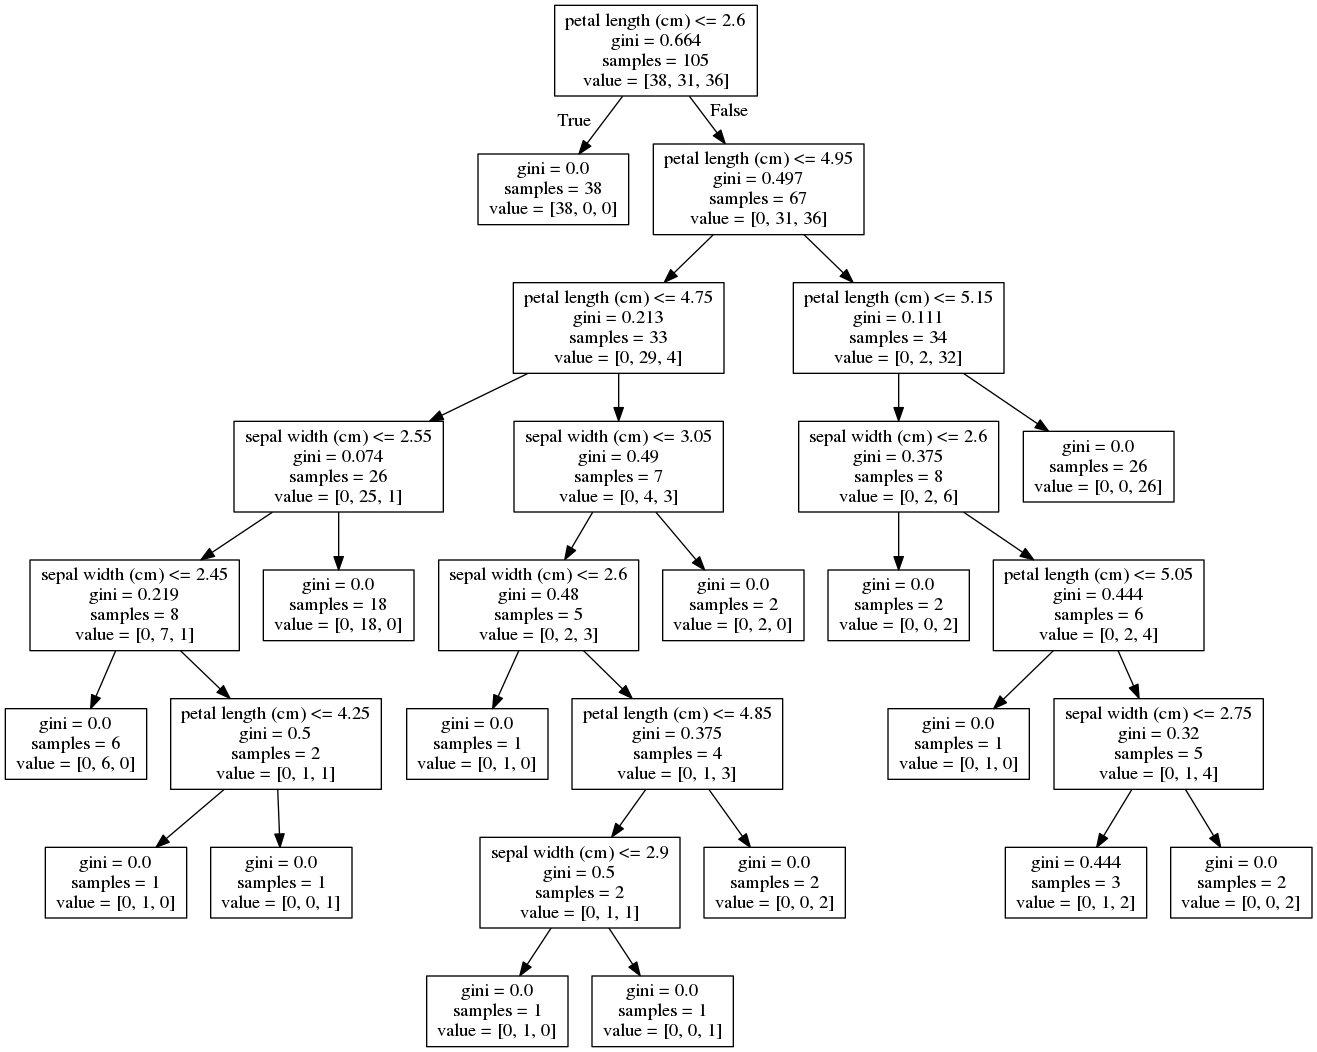

In [41]:
draw_decision_tree(clf, fn)

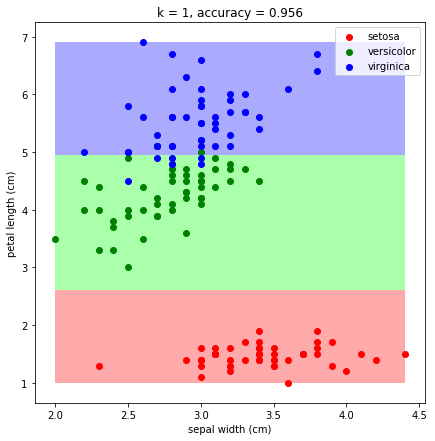

In [42]:
clf = magic_plot(DecisionTreeClassifier(max_depth=2))

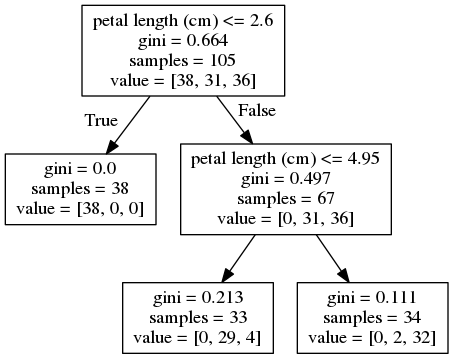

In [43]:
draw_decision_tree(clf, fn)

А упало ли значимо качество?

____________________
# 2. Простой градиентный бустинг

In [100]:
data = sklearn.datasets.load_boston()
print(data.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [101]:
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(379, 13) (127, 13) (379,) (127,)


In [127]:
class GradientBoosting:
    def __init__(self, coeff):
        self.get_coeff = coeff
        
    def antigrad(y, pred):
        return -2 * (pred - y)

    def fit(self, X, y):
        estimator = DecisionTreeRegressor(max_depth=5, random_state=42)
        estimator.fit(X, y)

        self.base_algorithms_list = [estimator]
        self.coefficients_list = [self.get_coeff(0)]

        for i in range(1, 50):
            estimator = DecisionTreeRegressor(max_depth=5, random_state=42)
            pred = self.predict(X)
            s = GradientBoosting.antigrad(y, pred)
            estimator.fit(X, s)
            self.base_algorithms_list.append(estimator)
            self.coefficients_list.append(self.get_coeff(i))
            
    def predict(self, X):
        return [
                sum([coeff * algo.predict([x])[0]
                     for algo, coeff in zip(self.base_algorithms_list, self.coefficients_list)])
                        for x in X]
    
    def predict_pref(self, X, i):
        return [
                sum([coeff * algo.predict([x])[0]
                     for algo, coeff in zip(self.base_algorithms_list[:i], self.coefficients_list[:i])])
                        for x in X]
    
    def get_mse_diagram(self, X, y):
        grid = np.arange(len(self.base_algorithms_list)) + 1
        MSE = [mean_squared_error(self.predict_pref(X, i), y)
               for i in grid]
        return grid, MSE

In [144]:
estimator_1 = GradientBoosting(coeff = lambda i : 0.1)
estimator_1.fit(X_train, y_train)
grid, MSE_1 = estimator_1.get_mse_diagram(X_test, y_test)

estimator_2 = GradientBoosting(coeff = lambda i : 0.1 / (1.0 + i))
estimator_2.fit(X_train, y_train)
grid, MSE_2 = estimator_2.get_mse_diagram(X_test, y_test)

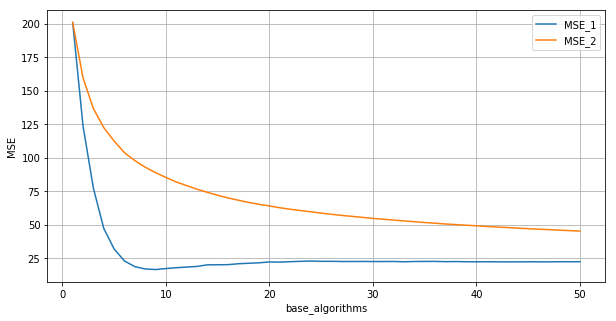

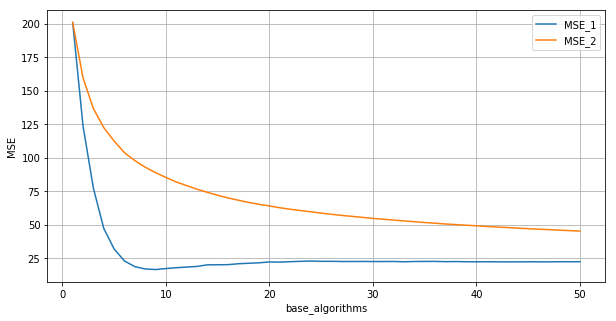

In [148]:
plt.figure(figsize=(10, 5))
plt.plot(grid, MSE_1, label="MSE_1")
plt.plot(grid, MSE_2, label="MSE_2")
plt.ylabel("MSE")
plt.xlabel("base_algorithms")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(grid, MSE_1, label="MSE_1")
plt.plot(grid, MSE_2, label="MSE_2")
plt.ylabel("MSE")
plt.xlabel("base_algorithms")
plt.legend()
plt.grid()
plt.show()



In [151]:
print(mean_squared_error(estimator_1.predict(X_test), y_test)**0.5)
print(mean_squared_error(estimator_2.predict(X_test), y_test)**0.5)

4.742088068434624
6.734924866336183


Попытайтесь выставить коэффициент 0.9, 0.9 / (1 + i) и посмотрите, что будет. Попробуйте подобрать хорошее правило выбора коэффициентов.

### sklearn / XGBoost

In [109]:
result_xgb = []
result_sklearn = []
ns_estimators = np.arange(2, 301, 5) + 1
for n_estimators in ns_estimators:
    estimator = xgb.XGBRegressor(n_estimators=n_estimators)
    estimator.fit(X_train, y_train)
    result_xgb.append(mean_squared_error(estimator.predict(X_test), y_test))
    
    estimator = GradientBoostingRegressor(n_estimators=n_estimators)
    estimator.fit(X_train, y_train)
    result_sklearn.append(mean_squared_error(estimator.predict(X_test), y_test))

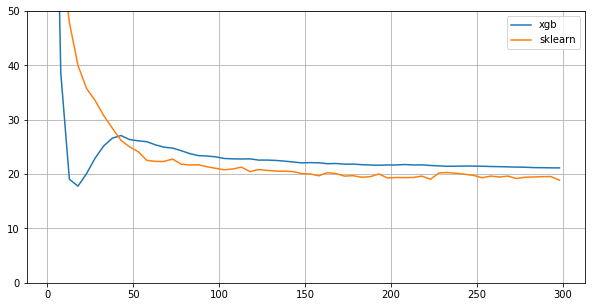

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(ns_estimators, result_xgb, label="xgb")
plt.plot(ns_estimators, result_sklearn, label="sklearn")
plt.grid()
plt.legend()
plt.ylim((0, 50))
plt.show()

In [117]:
print(np.array(result_xgb).min() ** 0.5)
print(np.array(result_sklearn).min() ** 0.5)

4.216876059350574
4.344989548243095


### Случайный лес

In [129]:
result_rf = []
ns_estimators = np.arange(2, 301, 5) + 1
for n_estimators in ns_estimators:
    estimator = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
    estimator.fit(X_train, y_train)
    result_rf.append(mean_squared_error(estimator.predict(X_test), y_test))

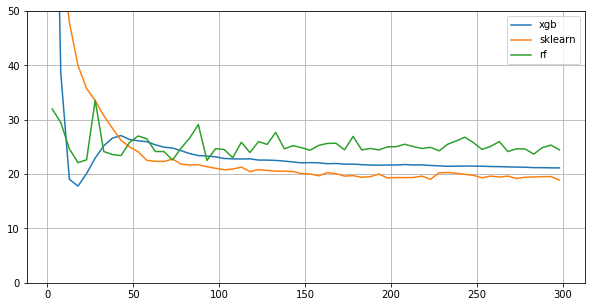

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(ns_estimators, result_xgb, label="xgb")
plt.plot(ns_estimators, result_sklearn, label="sklearn")
plt.plot(ns_estimators, result_rf, label="rf")
plt.grid()
plt.legend()
plt.ylim((0, 50))
plt.show()

In [135]:
estimator = RandomForestRegressor(n_estimators=5000, n_jobs=-1)
estimator.fit(X_train, y_train)
mean_squared_error(estimator.predict(X_test), y_test) ** 0.5

5.030635091665036

In [163]:
estimator = DecisionTreeRegressor(random_state=3)
estimator.fit(X_train, y_train)
mean_squared_error(estimator.predict(X_test), y_test) ** 0.5

5.828189708270532

Сравните качество с какой-нибудь известной вам моделью, кроме деревьев и ансамблей

In [164]:
estimator = Lasso()
estimator.fit(X_train, y_train)
mean_squared_error(estimator.predict(X_test), y_test) ** 0.5

6.469092839181131

In [166]:
estimator = Ridge()
estimator.fit(X_train, y_train)
mean_squared_error(estimator.predict(X_test), y_test) ** 0.5

7.981956116296526

# 3. Решающее дерево

In [167]:
def getp(y):
    uniq, counts = np.unique(y, return_counts=True)
    p = counts /  float(len(y))
    return p

def entropy(y):  
    p = getp(y)
    return - (p * np.log2(p)).sum()

def gini(y):
    p = getp(y)
    return 1. - (p**2).sum()

def variance(y):
    return y.std(ddof=0)

def mad_median(y):
    return (np.abs(y - np.median(y))).mean()

def most_often(y):
    uniq, counts = np.unique(y, return_counts=True)
    return uniq[counts.argmax()]

In [221]:
class DecisionTree(BaseEstimator):
    def __init__(self, max_depth=np.inf, min_samples_split=2,
                 criterion='gini', debug=False, classes=None):  # max_split_step
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.debug = debug
        self._classes = classes

        self._criterion_map = {
            "gini": gini,
            "entropy": entropy,
            "variance": variance,
            "mad_median": mad_median
        }
        self._criterion_func = self._criterion_map[criterion]
        # self.max_split_step = max_split_step

    def get_params(self, deep=False):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "criterion": self.criterion,
            "debug": self.debug,
        }

    def fit(self, X, y, categorical=None):
        assert len(X.shape) == 2
        assert len(y.shape) == 1
        assert X.shape[0] == len(y)
        assert len(y) > 0
        assert (categorical is None) or (len(categorical) == X.shape[1])

        return self._raw_fit(X, y, categorical)

    def _raw_fit(self, X, y, categorical=None):
        if self.debug:
            print("Fit")
            print(X)
            print(y)

        self._leaf = False

        self._features_count = X.shape[1]
        best_scores = None
        F = self._criterion_func

        uniq_targets = np.unique(y)
        if ((self.max_depth == 0) or (len(uniq_targets) == 1)
                or (X.shape[0] < self.min_samples_split)):
            self._leaf = True
            
            if self.criterion == "variance":
                self._prediction = y.mean()
            elif self.criterion == "mad_median":
                self._prediction = np.median(y)
            else:
                self._prediction = most_often(y)
                
            return

        F_y = F(y)
        for f_i in range(self._features_count):
            uniq_values = np.unique(X[:, f_i])
            if (not categorical is None) and (categorical[f_i]):
                borders = uniq_values
            else:
                borders = (uniq_values[:-1] + uniq_values[1:]) / 2.

            for value in borders:
                y_l = y[X[:, f_i] < value]
                y_r = y[X[:, f_i] >= value]
                if len(y_l) > 0 and len(y_r) > 0:
                    k_l = float(len(y_l)) / len(y)
                    k_r = float(len(y_r)) / len(y)
                    F_score = F_y - k_l * F(y_l) - k_r * F(y_r)

                    score = (F_score, f_i, value)
                    if (best_scores is None) or (best_scores < score):
                        best_scores = score

        self._f_i = best_scores[1]
        self._value = best_scores[2]

        params = self.get_params()
        params["max_depth"] = params["max_depth"] - 1
        params["classes"] = self._classes
        self._lson = DecisionTree(**params)
        self._rson = DecisionTree(**params)

        l_indexes = X[:, self._f_i] < self._value
        r_indexes = True ^ l_indexes
        self._lson.fit(X[l_indexes, :], y[l_indexes])
        self._rson.fit(X[r_indexes, :], y[r_indexes])

    def _raw_predict(self, X):
        if X.shape[0] == 0:
            return np.empty(shape=(0))
        
        if self._leaf:
            return np.array([self._prediction] * X.shape[0])

        l_indexes = X[:, self._f_i] < self._value
        r_indexes = True ^ l_indexes
        l_predictions = self._lson._raw_predict(X[l_indexes, :])
        r_predictions = self._rson._raw_predict(X[r_indexes, :])

        dtype = l_predictions.dtype if len(l_predictions) > 0 else r_predictions.dtype
        prediction = None

        prediction = np.empty(shape=X.shape[0], dtype=dtype)
        prediction[l_indexes] = l_predictions
        prediction[r_indexes] = r_predictions

        return prediction

    def predict(self, X):
        assert len(X.shape) == 2
        assert X.shape[1] == self._features_count
        return self._raw_predict(X)

_____________________
Оценим качество классификации

In [222]:
digits = sklearn.datasets.load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [223]:
X = digits.data
y = digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [231]:
dt = DecisionTree(max_depth=7, criterion="gini")
print(DecisionTree)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class '__main__.DecisionTree'>


0.8277777777777777

In [232]:
dt = DecisionTree(max_depth=7, criterion="entropy")
print(DecisionTree)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class '__main__.DecisionTree'>


0.8888888888888888

In [234]:
dt = DecisionTreeClassifier(max_depth=7)
print(DecisionTreeClassifier)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>


0.8277777777777777

In [235]:
dt = DecisionTreeClassifier(max_depth=7, criterion="entropy")
print(DecisionTreeClassifier)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>


0.8861111111111111

In [236]:
%%time
param_grid = {"max_depth":range(3, 11), "criterion":["gini", "entropy"]}
model = DecisionTree()
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)
gscv.fit(X, y)
gscv

CPU times: user 2.69 s, sys: 76.6 ms, total: 2.77 s
Wall time: 26.2 s


In [237]:
gscv.best_score_, gscv.best_params_

(0.8174735670562048, {'criterion': 'entropy', 'max_depth': 9})

In [238]:
import warnings
warnings.filterwarnings("ignore")

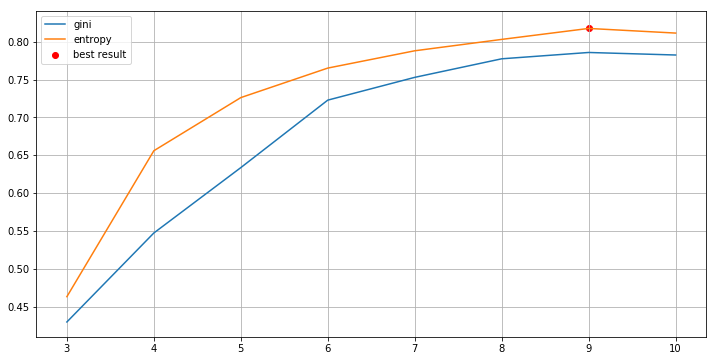

In [239]:
plt.figure(figsize=(12, 6))
for bounds in [(0, 11 -3), (11-3, 2 * (11-3))]:
    grid = [gscv.grid_scores_[i][0]["max_depth"] for i in range(*bounds)]
    accuracy = [gscv.grid_scores_[i][1] for i in range(*bounds)]
    criterion = gscv.grid_scores_[bounds[0]][0]["criterion"]
    plt.plot(grid, accuracy, label=criterion)
plt.scatter([gscv.best_params_["max_depth"]], [gscv.best_score_], color="red", label="best result")
plt.grid()
plt.legend()
plt.show()

________________
Оценим качество регрессии

In [240]:
boston = sklearn.datasets.load_boston()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [241]:
from sklearn.metrics import mean_squared_error
for criterion in ["variance", "mad_median"]:
    dt = DecisionTree(criterion=criterion, max_depth=7)
    dt.fit(X_train, y_train)
    mse = mean_squared_error(dt.predict(X_test), y_test)
    print("My DT. Criterion = {}, score = {}".format(criterion, mse))

My DT. Criterion = variance, score = 13.605277948202792
My DT. Criterion = mad_median, score = 17.532058823529404


In [192]:
from sklearn.tree import DecisionTreeRegressor
for  criterion in ["mse", "mae"]:
    dt = DecisionTreeRegressor(criterion=criterion, max_depth=7)
    dt.fit(X_train, y_train)
    mse = mean_squared_error(dt.predict(X_test), y_test)
    print("Sklearn DT : Criterion = {}, score = {}".format(criterion, mse))

Sklearn DT : Criterion = mse, score = 7.813319268341722
Sklearn DT : Criterion = mae, score = 30.692009803921568


In [193]:
from sklearn.tree import DecisionTreeRegressor
for  criterion in ["mse", "mae"]:
    dt = DecisionTreeRegressor(criterion=criterion, max_depth=7)
    dt.fit(X_train, y_train)
    mse = mean_squared_error(dt.predict(X_test), y_test)
    print("Sklearn DT : Criterion = {}, score = {}".format(criterion, mse))

Sklearn DT : Criterion = mse, score = 8.225633865291616
Sklearn DT : Criterion = mae, score = 29.905955882352938


In [202]:
%%time
param_grid = {"max_depth":range(2, 19), "criterion":["variance", "mad_median"]}
model = DecisionTree()
print(type(model))
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
gscv.fit(X, y)
gscv

<class '__main__.DecisionTree'>
CPU times: user 1.54 s, sys: 79.5 ms, total: 1.62 s
Wall time: 58.9 s


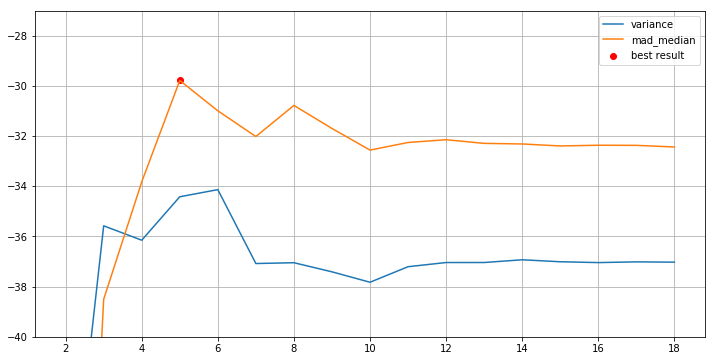

In [203]:
plt.figure(figsize=(12, 6))
l = int(len(gscv.grid_scores_) / 2)

for bounds in [(0, l), (l, 2 * l)]:
    grid = [gscv.grid_scores_[i][0]["max_depth"] for i in range(*bounds)]
    accuracy = [gscv.grid_scores_[i][1] for i in range(*bounds)]
    criterion = gscv.grid_scores_[bounds[0]][0]["criterion"]
    plt.plot(grid, accuracy, label=criterion)
plt.scatter([gscv.best_params_["max_depth"]], [gscv.best_score_], color="red", label="best result")
plt.grid()
plt.legend()
plt.ylim((-40, -27))
plt.show()